## CIFAR 10

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.conv_learner import *
PATH = 'data/cifar/'
os.makedirs(PATH, exist_ok=True)

You can get the data via:

    wget http://pjreddie.com/media/files/cifar.tgz

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [4]:
def to_label_subdirs(path, subdirs, classes, labelfn):
    for sd in subdirs:
        for rf in os.listdir(os.path.join(path, sd)):
            af = os.path.join(path, sd, rf)
            if not os.path.isfile(af):
                continue
            lb = labelfn(rf)
            if not lb:
                continue
            os.renames(af, os.path.join(path, sd, lb, rf))

In [5]:
to_label_subdirs(PATH, 'train test'.split(), classes, lambda f: f[f.find('_') + 1 : f.find('.')])

In [6]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz // 8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [7]:
bs=256

### Look at data

In [8]:
data = get_data(32, 4)

In [9]:
x, y = next(iter(data.trn_dl))

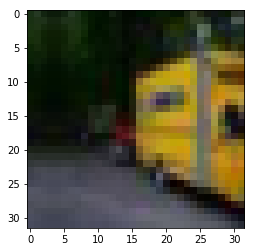

In [10]:
plt.imshow(data.trn_ds.denorm(x)[0])

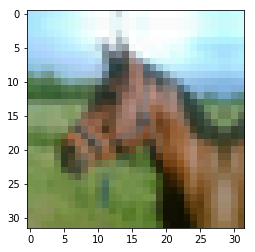

In [11]:
plt.imshow(data.trn_ds.denorm(x)[1])

## Fully connected model

In [12]:
data = get_data(32, bs)

In [13]:
lr = 1e-2

From [this notebook](https://github.com/KeremTurgutlu/deeplearning/blob/master/Exploring%20Optimizers.ipynb) by our student Kerem Turgutlu:

In [14]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [15]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40, 10]), data)

In [16]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40)
     (1): Linear(in_features=40, out_features=10)
   )
 ), [122880, 40, 400, 10])

In [17]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [18]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 76%|███████▌  | 148/196 [00:15<00:05,  9.40it/s, loss=10]  

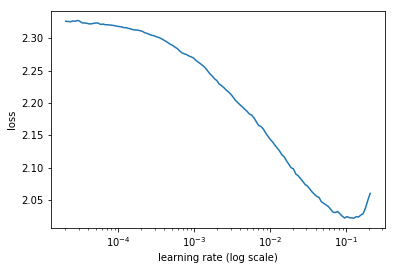

 76%|███████▌  | 148/196 [00:30<00:09,  4.93it/s, loss=10]

In [19]:
learn.sched.plot()

In [20]:
%time learn.fit(lr, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

 13%|█▎        | 26/196 [00:03<00:20,  8.22it/s, loss=2.05]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      1.766196   1.642816   0.419     
    1      1.675517   1.568509   0.4466                     

CPU times: user 1min 38s, sys: 2min 51s, total: 4min 29s
Wall time: 44.3 s


[array([1.56851]), 0.4466]

In [21]:
%time learn.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.617357   1.515796   0.4654    
    1      1.582096   1.496592   0.4684                     

CPU times: user 1min 37s, sys: 2min 46s, total: 4min 23s
Wall time: 43.5 s


[array([1.49659]), 0.4684]

## CNN

In [22]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [23]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

In [24]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

In [25]:
learn.lr_find(end_lr=100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 98%|█████████▊| 192/196 [00:18<00:00, 10.29it/s, loss=10.1]

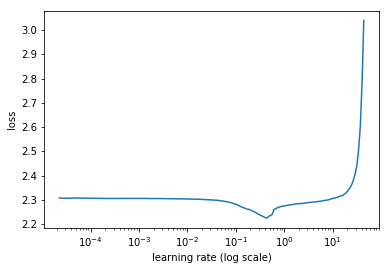

 98%|█████████▊| 192/196 [00:30<00:00,  6.39it/s, loss=10.1]

In [26]:
learn.sched.plot()

In [27]:
%time learn.fit(1e-1, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

 16%|█▋        | 32/196 [00:03<00:17,  9.50it/s, loss=2.2] 

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      1.711504   1.737088   0.3824    
    1      1.52142    1.558574   0.4381                     

CPU times: user 1min 38s, sys: 2min 51s, total: 4min 29s
Wall time: 44 s


[array([1.55857]), 0.4381]

In [28]:
%time learn.fit(1e-1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.456638   1.38682    0.5034    
    1      1.357452   1.284294   0.5388                     
    2      1.296569   1.239791   0.5547                     
    3      1.264639   1.205657   0.5701                     

CPU times: user 3min 21s, sys: 5min 45s, total: 9min 7s
Wall time: 1min 27s


[array([1.20566]), 0.5701]

## Refactored

In [29]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [30]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [31]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [32]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [33]:
%time learn.fit(1e-1, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.728346   1.639025   0.4117    
    1      1.513297   1.399134   0.4903                     

CPU times: user 1min 42s, sys: 2min 48s, total: 4min 31s
Wall time: 44.2 s


[array([1.39913]), 0.4903]

In [34]:
%time learn.fit(1e-1, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.322032   1.260205   0.5485    
    1      1.274674   1.20203    0.5723                     

CPU times: user 1min 38s, sys: 2min 52s, total: 4min 30s
Wall time: 44.3 s


[array([1.20203]), 0.5723]

## BatchNorm

In [35]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf, 1, 1))
        self.m = nn.Parameter(torch.ones(nf, 1, 1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0, 1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:, None, None]
            self.stds  = x_chan.std (1)[:, None, None]
        return (x-self.means) / self.stds * self.m + self.a

In [36]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [37]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [38]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict([

In [39]:
%time learn.fit(3e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.474475   1.421361   0.4984    
    1      1.264842   1.144034   0.5881                     

CPU times: user 1min 56s, sys: 3min 24s, total: 5min 21s
Wall time: 47.6 s


[array([1.14403]), 0.5881]

In [40]:
%time learn.fit(1e-1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.168034   1.030074   0.6267    
    1      1.030772   0.96697    0.6655                     
    2      0.964813   0.872289   0.696                       
    3      0.905667   0.837793   0.7079                      

CPU times: user 3min 53s, sys: 6min 43s, total: 10min 36s
Wall time: 1min 34s


[array([0.83779]), 0.7079]

## Deep BatchNorm

In [41]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i + 1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [42]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [43]:
%time learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.505403   1.369886   0.4972    
    1      1.292517   1.193988   0.5743                     

CPU times: user 2min 7s, sys: 3min 40s, total: 5min 47s
Wall time: 50.9 s


[array([1.19399]), 0.5743]

In [44]:
%time learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.114137   1.040168   0.6291    
    1      1.034688   0.982892   0.6514                     

CPU times: user 2min 5s, sys: 3min 42s, total: 5min 47s
Wall time: 51.3 s


[array([0.98289]), 0.6514]

## Resnet

In [45]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [46]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i + 1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i + 1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [47]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [48]:
wd = 1e-5

In [49]:
%time learn.fit(1e-2, 2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.555916   1.497878   0.4593    
    1      1.286486   1.179735   0.5811                     

CPU times: user 2min 11s, sys: 3min 50s, total: 6min 2s
Wall time: 56.1 s


[array([1.17973]), 0.5811]

In [50]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.075466   1.038314   0.6273    
    1      1.047439   0.991257   0.6495                     
    2      0.931519   0.911734   0.6783                      
    3      0.96682    0.917621   0.6752                      
    4      0.860942   0.831846   0.7079                      
    5      0.760845   0.758946   0.7312                      
    6      0.723117   0.757247   0.7335                      

CPU times: user 7min 40s, sys: 13min 20s, total: 21min
Wall time: 3min 14s


[array([0.75725]), 0.7335]

In [51]:
%time learn.fit(1e-2, 4, cycle_len=4, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=16), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.821457   0.828655   0.7095    
    1      0.735682   0.729878   0.7426                      
    2      0.67023    0.709068   0.7555                      
    3      0.614033   0.68396    0.7587                      
    4      0.72356    0.731519   0.7446                      
    5      0.646835   0.666082   0.7637                      
    6      0.587808   0.630712   0.7811                      
    7      0.538311   0.63509    0.7782                      
    8      0.653226   0.719071   0.7544                      
    9      0.587378   0.638724   0.779                       
    10     0.53147    0.606534   0.791                       
    11     0.486855   0.574349   0.8018                      
    12     0.60116    0.674546   0.7682                      
    13     0.536271   0.590718   0.793                       
    14     0.478524   0.577702   0.8039                      
    15     0.439396   0.58

[array([0.58948]), 0.7972]

## Resnet 2

In [52]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i + 1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i + 1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [53]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [54]:
wd = 1e-6

In [55]:
%time learn.fit(1e-2, 2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.726595   1.476193   0.477     
    1      1.511903   1.594056   0.5248                     

CPU times: user 2min 33s, sys: 4min 11s, total: 6min 44s
Wall time: 1min 7s


[array([1.59406]), 0.5248]

In [56]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.246219   1.123039   0.5994    
    1      1.205521   1.079559   0.6165                     
    2      1.047397   0.982982   0.6518                     
    3      1.11306    1.042084   0.643                      
    4      0.986444   0.938702   0.6705                      
    5      0.86359    0.827887   0.7107                      
    6      0.820836   0.859191   0.6998                      

CPU times: user 8min 53s, sys: 14min 50s, total: 23min 43s
Wall time: 3min 58s


[array([0.85919]), 0.6998]

In [57]:
%time learn.fit(1e-2, 4, cycle_len=4, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=16), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.922289   0.922782   0.6783    
    1      0.843655   0.815614   0.7125                      
    2      0.733954   0.732746   0.7458                      
    3      0.695225   0.732575   0.7457                      
    4      0.826921   0.759739   0.7323                      
    5      0.731842   0.704877   0.7553                      
    6      0.642404   0.659563   0.7721                      
    7      0.605025   0.728076   0.7616                      
    8      0.72092    0.719592   0.7534                      
    9      0.652721   0.653841   0.776                       
    10     0.583139   0.606309   0.7903                      
    11     0.535503   0.64212    0.7817                      
    12     0.656404   0.654129   0.7783                      
    13     0.587746   0.655965   0.7777                      
    14     0.518367   0.601116   0.7925                      
    15     0.489359   0.59

[array([0.59791]), 0.7945]